<a href="https://colab.research.google.com/github/Tejaswini-Gsl/neural-networks/blob/main/model(lan).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
import librosa as lr
import shutil
import dask.array as da
import h5py
import glob
# import resampy
import imageio
from PIL import Image



importing datasets

In [5]:


# other_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/other.tsv', sep='\t')
validate_sen_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/validated.tsv', sep='\t')
# unvalidate_sen_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/en/invalidated.tsv', sep='\t')

# other_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/other.tsv', sep='\t')
validate_sen_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/validated.tsv', sep='\t')
# unvalidate_sen_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/ca/invalidated.tsv', sep='\t')

print(validate_sen_df_en.shape,validate_sen_df_ca.shape)


(1877, 13) (1586, 13)


data preprocessing

In [6]:
def load_audio(file_path, sr=16000):#Load an audio file into an array.
    data,sr = lr.load(file_path)
    return data

validate_sen_df_en['audio'] = validate_sen_df_en['path'].apply(lambda x: load_audio(f'/content/drive/MyDrive/neural dataset/en/clips/{x}'))
validate_sen_df_ca['audio'] = validate_sen_df_ca['path'].apply(lambda x: load_audio(f'/content/drive/MyDrive/neural dataset/ca/val_clips/{x}'))


In [7]:
validate_sen_df_ca.head(1)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,audio
0,0bf9a3c9eebf8e427fa1d08800532c4bb279c13c113446...,common_voice_ca_39702834.mp3,d159405abc07362ede5b393be7a63233f72fdc766a3186...,La finalització de la guerra obrí un tens perí...,NaN,2,0,fourties,female_feminine,NaN,NaN,ca,NaN,"[-3.9815347e-12, -8.749569e-13, -4.1578212e-12..."


(optional) saving and importing csv files

In [8]:
# # df_total = pd.concat([validate_sen_df_en,validate_sen_df_ca], axis=0)
# # df_total.shape
# validate_sen_df_en.to_csv('/content/drive/MyDrive/neural dataset/data_en.csv', index=False)
# validate_sen_df_ca.to_csv('/content/drive/MyDrive/neural dataset/data_ca.csv', index=False)

# validate_sen_df_en = pd.read_csv('/content/drive/MyDrive/neural dataset/data_en.csv')
# validate_sen_df_ca = pd.read_csv('/content/drive/MyDrive/neural dataset/data_ca.csv')

In [9]:
df_total = pd.concat([validate_sen_df_en,validate_sen_df_ca], axis=0) # combining language(en,ca) df into
df_total.head(1)

,client_id,path,sentence_id,sentence,sentence_domain,up_votes,down_votes,age,gender,accents,variant,locale,segment,audio
0,01e8ea298cdecf26e273f5baac3915eb992c493f229686...,common_voice_en_39751075.mp3,e5e7d4694b7160add018a08876327f254690c1ab4c39ea...,Madin was a significant figure of post-war Bir...,NaN,2,0,NaN,NaN,"United States English,New York English",NaN,en,NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [10]:
import librosa as lr

# def extract_features(audio, n_mfcc=13, hop_length=512, n_fft=2048):
#     mfcc = lr.feature.mfcc(y=audio, sr=16000, n_mfcc=n_mfcc,
#                            hop_length=hop_length, n_fft=n_fft)
#     return mfcc.T  # Transpose to align time to rows
# df_total['features'] = df_total['audio'].apply(extract_features)

# Extract mel spectrogram features from an audio signal.
def extract_features(audio, n_mels=128, hop_length=512, n_fft=2048):
    mel_spectrogram = lr.feature.melspectrogram(y=audio, sr=16000, n_mels=n_mels,
                                                hop_length=hop_length, n_fft=n_fft)
    return mel_spectrogram.T  # Transpose to align time to rows

# Assuming df_total['audio'] contains the audio data
df_total['features'] = df_total['audio'].apply(extract_features)

# Print the shapes of the extracted features
print(df_total['features'][0].shape)  # Assuming you want to check the shape of the first sample



(2,)


Mean mel-spectrogram length: 220.74
Median mel-spectrogram length: 214.0
90th percentile mel-spectrogram length: 311.8000000000002
95th percentile mel-spectrogram length: 338.0


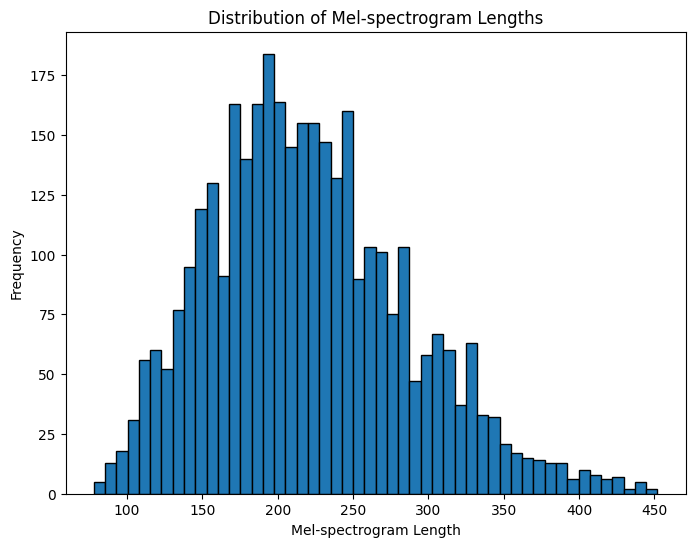

In [11]:
import matplotlib.pyplot as plt
import numpy as np

features_lengths = []
for features in df_total['features']:
    features_lengths.append(features.shape[0])
# Calculate statistics
mean_length = np.mean(features_lengths)
median_length = np.median(features_lengths)
percentile_90 = np.percentile(features_lengths, 90)
percentile_95 = np.percentile(features_lengths, 95)

print(f"Mean mel-spectrogram length: {mean_length:.2f}")
print(f"Median mel-spectrogram length: {median_length}")
print(f"90th percentile mel-spectrogram length: {percentile_90}")
print(f"95th percentile mel-spectrogram length: {percentile_95}")

# Plot a histogram
plt.figure(figsize=(8, 6))
plt.hist(features_lengths, bins=50, edgecolor='black')
plt.xlabel('Mel-spectrogram Length')
plt.ylabel('Frequency')
plt.title('Distribution of Mel-spectrogram Lengths')
plt.show()

In [12]:
import numpy as np

# Assuming you have a maximum length for the features
max_length = 256  # Replace with the desired maximum length based on percentile mel-spectrogram length

# Define a padding function
def pad_features(features, max_length):
    padded_features = np.zeros((max_length, features.shape[1]))
    if features.shape[0] > max_length:
        padded_features = features[:max_length, :]
    else:
        padded_features[:features.shape[0], :] = features
    return padded_features

# Pad the features in the dataframes
df_total['features'] = df_total['features'].apply(lambda x: pad_features(x, max_length))

# Now you can convert the features to NumPy arrays
X = np.array(df_total['features'].tolist())
# y_domain =(df_total['sentence_domain'])
y_lan = (df_total['locale'])


In [14]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Assuming df_total['locale'] and df_total['sentence_domain'] are the columns with string labels
# Initialize label encoders
label_encoder_lang = LabelEncoder()
# label_encoder_domain = LabelEncoder()

# Fit label encoder and return encoded labels
y_lan = label_encoder_lang.fit_transform(df_total['locale'].dropna())

# Get the number of classes from the fitted label encoder
num_language_classes = len(label_encoder_lang.classes_)

# Convert labels to one-hot encoding
y_lan_encoded = to_categorical(y_lan, num_classes=num_language_classes)
y_lan_encoded.shape

(3463, 2)

In [15]:
X.shape,y_lan_encoded.shape

((3463, 256, 128), (3463, 2))

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_lan_train, y_lan_test = train_test_split(
    X, y_lan_encoded, test_size=0.3, random_state=42
)

# Optionally, split the training set further to create a validation set (e.g., 80% of the remaining train for training, 20% for validation)
X_train, X_val, y_lan_train, y_lan_val = train_test_split(
    X_train, y_lan_train, test_size=0.2, random_state=42
)


# Check the shape of each set to ensure everything is correct
print("Training set:", X_train.shape, y_lan_train.shape)
print("Validation set:", X_val.shape ,y_lan_val.shape)
print("Test set:", X_test.shape, y_lan_test.shape)

Training set: (1939, 256, 128) (1939, 2)
Validation set: (485, 256, 128) (485, 2)
Test set: (1039, 256, 128) (1039, 2)


In [17]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)/ 255.0
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)/ 255.0
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)/255.0

In [19]:
num_language_classes=  y_lan_test.shape[-1]
num_domain_classes = 11
X_train.shape


(1939, 256, 128, 1)

# Model 1 : CNN

In [21]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers

# Define the CNN model
def create_cnn_model(input_shape, num_domain_classes, num_language_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # First conv layer
        layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Second conv layer
        layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),

        # Third conv layer
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.25),



        # Flatten the output of the conv layers to feed into the dense layer
        layers.Flatten(),

        # Dense layer for feature interpretation
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),

        # Separate output layers for domain and language classification
        layers.Dense(num_language_classes, activation='softmax'),
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Assuming you have already defined input_shape, num_domain_classes, and num_language_classes
input_shape = X_train[0].shape  # Example: (MFCC_Time, MFCC_Features, 1) e.g., (32, 13, 1)
print(input_shape)
# Create the model
model = create_cnn_model(input_shape, num_domain_classes, num_language_classes)

# Print the model summary
model.summary()


(256, 128, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 128, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128, 64, 32)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 64, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64, 

In [22]:
# fit the model
history = model.fit(X_train, y_lan_train,epochs=20,validation_data=(X_val,y_lan_val), batch_size=32)

Epoch 1/20
61/61 [==============================] - 200s 3s/step - loss: 0.6740 - accuracy: 0.5570 - val_loss: 0.6617 - val_accuracy: 0.6763
Epoch 2/20
61/61 [==============================] - 184s 3s/step - loss: 0.6400 - accuracy: 0.6142 - val_loss: 0.6170 - val_accuracy: 0.6268
Epoch 3/20
61/61 [==============================] - 169s 3s/step - loss: 0.5818 - accuracy: 0.7029 - val_loss: 0.6661 - val_accuracy: 0.6289
Epoch 4/20
61/61 [==============================] - 167s 3s/step - loss: 0.5246 - accuracy: 0.7457 - val_loss: 0.5474 - val_accuracy: 0.7423
Epoch 5/20
61/61 [==============================] - 167s 3s/step - loss: 0.4616 - accuracy: 0.7782 - val_loss: 0.5670 - val_accuracy: 0.7010
Epoch 6/20
61/61 [==============================] - 164s 3s/step - loss: 0.3940 - accuracy: 0.8231 - val_loss: 0.5005 - val_accuracy: 0.7814
Epoch 7/20
61/61 [==============================] - 173s 3s/step - loss: 0.3513 - accuracy: 0.8561 - val_loss: 0.6860 - val_accuracy: 0.6515
Epoch 8/20
61

# Model 2 : RNN

In [24]:
def create_rnn_model(input_shape, num_domain_classes, num_language_classes):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # LSTM layer
        layers.LSTM(64, return_sequences=True),

        # Dropout layer
        layers.Dropout(0.5),

        # LSTM layer
        layers.LSTM(64),

        # Dropout layer
        layers.Dropout(0.5),

        # Dense layer for feature interpretation
        layers.Dense(256, activation='relu'),

        # Output layer for language classification
        layers.Dense(num_language_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

input_shape1=X_train.shape[1:-1]
#  (X_train.shape[1],X_train.shape[2])
model_rnn = create_rnn_model(input_shape1, num_domain_classes, num_language_classes)

model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 256, 64)           49408     
                                                                 
 dropout_10 (Dropout)        (None, 256, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               16640     
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                                 
Total params: 99586 (389.01 KB)
Trainable params: 9958

In [25]:
# fit the model
history_rnn = model_rnn.fit(X_train, y_lan_train,epochs=20,validation_data=(X_val,y_lan_val), batch_size=32)

Epoch 1/20
61/61 [==============================] - 25s 348ms/step - loss: 0.6924 - accuracy: 0.5364 - val_loss: 0.6783 - val_accuracy: 0.5505
Epoch 2/20
61/61 [==============================] - 18s 290ms/step - loss: 0.6882 - accuracy: 0.5260 - val_loss: 0.6832 - val_accuracy: 0.5113
Epoch 3/20
61/61 [==============================] - 18s 290ms/step - loss: 0.6880 - accuracy: 0.5260 - val_loss: 0.6845 - val_accuracy: 0.4990
Epoch 4/20
61/61 [==============================] - 19s 320ms/step - loss: 0.6848 - accuracy: 0.5317 - val_loss: 0.6761 - val_accuracy: 0.5711
Epoch 5/20
61/61 [==============================] - 17s 285ms/step - loss: 0.6732 - accuracy: 0.5400 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 6/20
61/61 [==============================] - 18s 289ms/step - loss: 0.6748 - accuracy: 0.5627 - val_loss: 0.6914 - val_accuracy: 0.5546
Epoch 7/20
61/61 [==============================] - 21s 348ms/step - loss: 0.6834 - accuracy: 0.5291 - val_loss: 0.6568 - val_accuracy: 0.5608

# Model 3 : Transformer

In [26]:
from tensorflow.keras import layers, models

def create_transformer_model(input_shape, num_domain_classes, num_language_classes):
    # Encoder
    encoder_inputs = layers.Input(shape=input_shape)
    encoder_dense = layers.Flatten()(encoder_inputs)
    encoder_dense = layers.Dense(128, activation='relu')(encoder_dense)
    encoder_dense = layers.Dropout(0.5)(encoder_dense)
    encoder_output = layers.Dense(128, activation='relu')(encoder_dense)

    # Decoder
    decoder_inputs = layers.Input(shape=input_shape)
    decoder_dense = layers.Flatten()(decoder_inputs)
    decoder_dense = layers.Dense(128, activation='relu')(decoder_dense)
    decoder_dense = layers.Dropout(0.5)(decoder_dense)
    decoder_output = layers.Dense(128, activation='relu')(decoder_dense)

    # Output layers
    output = layers.Concatenate()([encoder_output, decoder_output])
    output = layers.Dense(256, activation='relu')(output)
    output = layers.Dropout(0.5)(output)
    language_output = layers.Dense(num_language_classes, activation='softmax')(output)
    # domain_output = layers.Dense(num_domain_classes, activation='softmax', name='domain_output')(output)

    # Build and compile the model
    model = models.Model(inputs=[encoder_inputs, decoder_inputs], outputs=language_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Example usage
input_shape = X_train.shape[1:]  # Input shape for the encoder

print(input_shape)
num_domain_classes = 10  # Number of domain classes
num_language_classes = 2  # Number of language classes

model_ts = create_transformer_model(input_shape, num_domain_classes, num_language_classes)
model_ts.summary()


(256, 128, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 256, 128, 1)]        0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 32768)                0         ['input_5[0][0]']             
                                                                                                  
 flatten_3 (Flatten)         (None, 32768)                0         ['input_6[0][0]']             
                                                                                

In [27]:
history_ts = model_ts.fit([X_train, X_train], y_lan_train, validation_data=([X_val, X_val], y_lan_val), epochs=20, batch_size=32)

Epoch 1/20
61/61 [==============================] - 9s 131ms/step - loss: 0.6774 - accuracy: 0.6204 - val_loss: 0.6584 - val_accuracy: 0.5979
Epoch 2/20
61/61 [==============================] - 10s 162ms/step - loss: 0.5612 - accuracy: 0.7385 - val_loss: 0.5726 - val_accuracy: 0.7216
Epoch 3/20
61/61 [==============================] - 7s 112ms/step - loss: 0.4076 - accuracy: 0.8272 - val_loss: 0.8435 - val_accuracy: 0.6948
Epoch 4/20
61/61 [==============================] - 6s 101ms/step - loss: 0.2903 - accuracy: 0.8907 - val_loss: 0.9645 - val_accuracy: 0.7134
Epoch 5/20
61/61 [==============================] - 7s 122ms/step - loss: 0.1877 - accuracy: 0.9376 - val_loss: 1.3221 - val_accuracy: 0.6845
Epoch 6/20
61/61 [==============================] - 6s 100ms/step - loss: 0.2023 - accuracy: 0.9443 - val_loss: 1.0228 - val_accuracy: 0.7196
Epoch 7/20
61/61 [==============================] - 7s 122ms/step - loss: 0.0872 - accuracy: 0.9732 - val_loss: 1.4009 - val_accuracy: 0.7237
Epoch

In [28]:
def eval_model(model, x, y, model_name):

    try:
        if model_name == 'Transformer':
            test_loss, test_accuracy = model.evaluate([x, x], y)
        else:
            test_loss, test_accuracy = model.evaluate(x, y)
        return test_loss, test_accuracy
    except Exception as e:
        print('Failed to evaluate model {}: {}'.format(model_name, e))
        return None, None

# Example usage and storing results:
results = {}
models = {'CNN': model, 'RNN': model_rnn, 'Transformer': model_ts}
for name, mod in models.items():
    loss, accuracy = eval_model(mod, X_test, y_lan_test, name)
    results[name] = (loss, accuracy)


33/33 [==============================] - 1s 28ms/step - loss: 2.5607 - accuracy: 0.7353


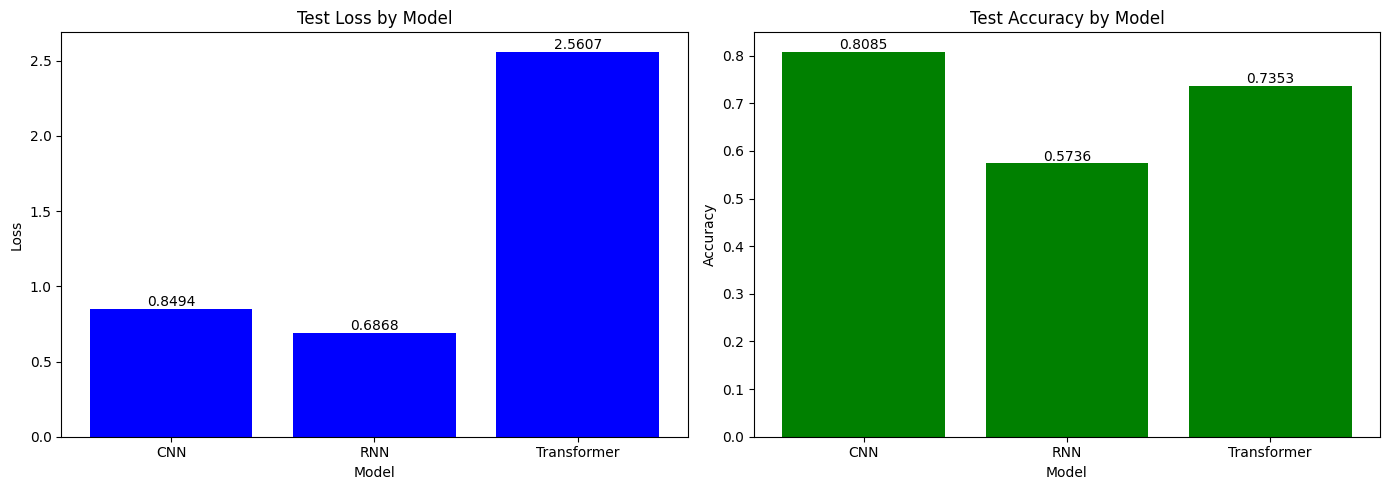

In [29]:
import matplotlib.pyplot as plt

# Assuming `results` is a dictionary containing the loss and accuracy
labels = list(results.keys())
loss_values = [results[name][0] for name in labels]
accuracy_values = [results[name][1] for name in labels]

# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plotting loss
ax[0].bar(labels, loss_values, color='blue')
ax[0].set_title('Test Loss by Model')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Model')

# Plotting accuracy
ax[1].bar(labels, accuracy_values, color='green')
ax[1].set_title('Test Accuracy by Model')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Model')

# Adding a legend
for a in ax:
    for p in a.patches:
        a.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                   textcoords='offset points')

plt.tight_layout()
plt.show()
